# Airbnb New User Bookings

# Importation des CSV et des libs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer

In [2]:
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')
sessions = pd.read_csv('sessions.csv')

# Exploration par dataset

## Train Dataset

Aperçu des données

In [3]:
print("------head-------")
print(train.head())
print("")
print("------info-------")
print(train.info())
print("")
print("------describe-------")
print(train.describe())


------head-------
           id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_t

Exploration des valeurs manquantes

In [4]:
print(train.isnull().sum())

print('--------------------------------------------------')


missing_percentage = train.isnull().mean() * 100
missing_percentage

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64
--------------------------------------------------


id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

Exploration des types de données et des valeurs uniques

In [5]:
# Afficher les types de données
print(train.dtypes)
print('--------------------------------------------------')
# Afficher le nombre de valeurs uniques pour chaque colonne
print(train.nunique())
print('--------------------------------------------------')
# Afficher les valeurs uniques pour quelques colonnes spécifiques
print(train['gender'].unique())
print(train['signup_method'].unique())
print(train['language'].unique())
print(train['affiliate_channel'].unique())


id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object
--------------------------------------------------
id                         213451
date_account_created         1634
timestamp_first_active     213451
date_first_booking           1976
gender                          4
age                           127
signup_method                   3
signup_flow                    17
language                       25
affiliate_channel               8
affiliate_provider             18
f

Exploration des distributions des variables

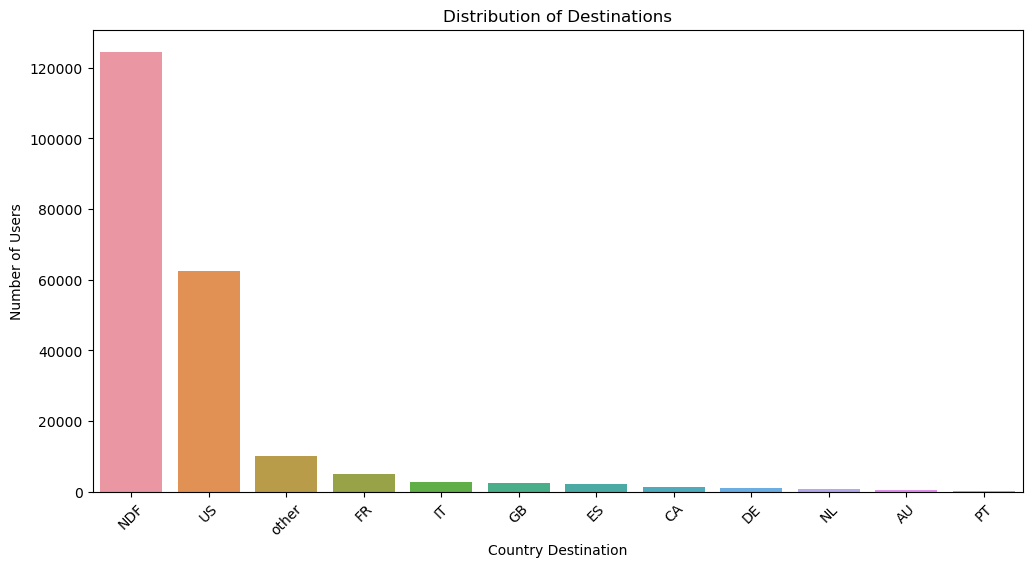

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='country_destination', order=train['country_destination'].value_counts().index)
plt.title('Distribution of Destinations')
plt.xlabel('Country Destination')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


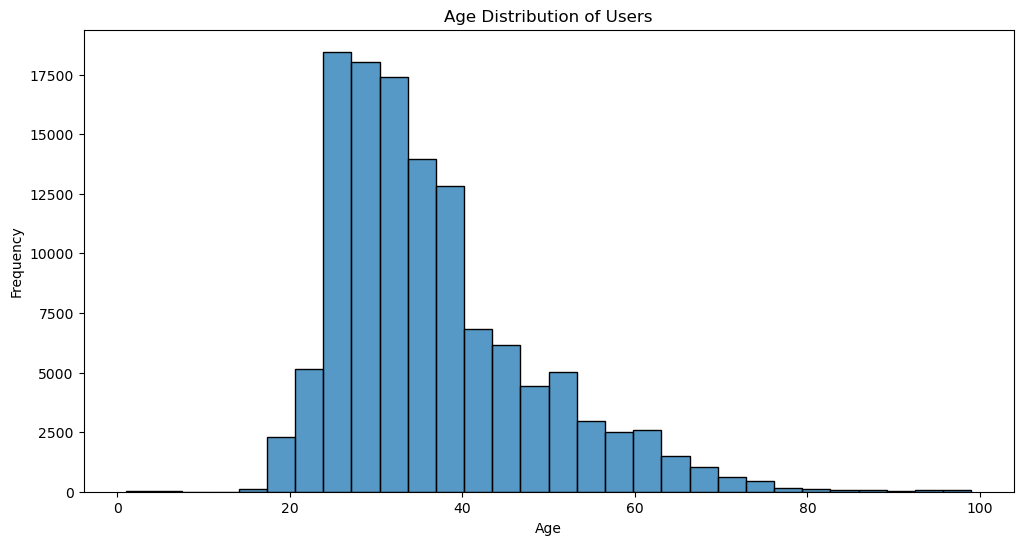

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(train[train['age'] < 100]['age'], bins=30, kde=False)  # Supposant que l'âge a des valeurs aberrantes au-dessus de 100
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


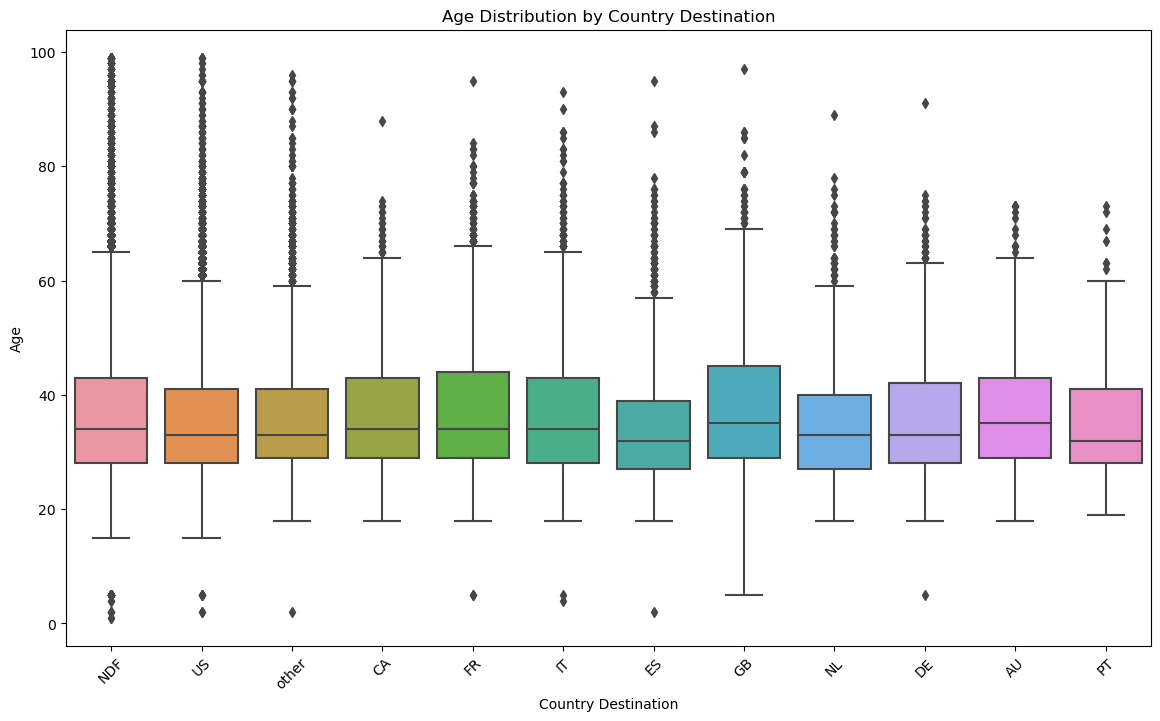

In [8]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=train[train['age'] < 100], x='country_destination', y='age')
plt.title('Age Distribution by Country Destination')
plt.xlabel('Country Destination')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()


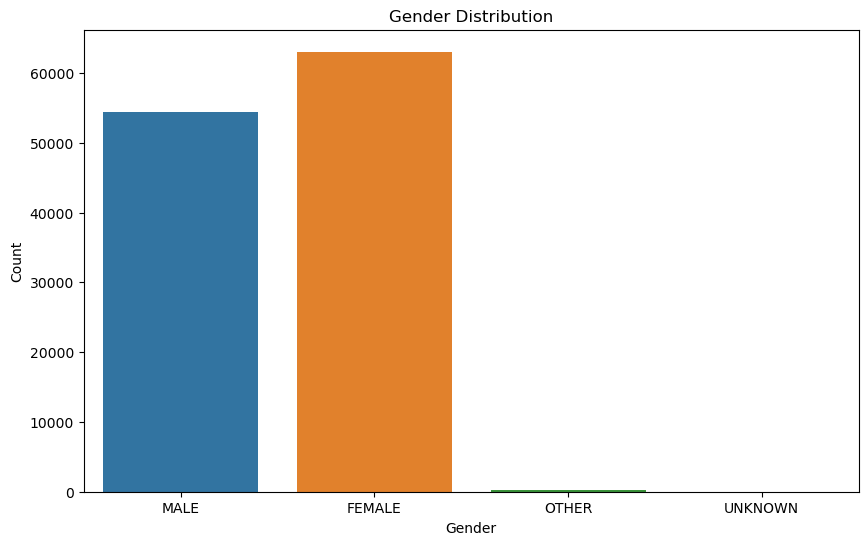

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='gender', order=['MALE', 'FEMALE', 'OTHER', 'UNKNOWN'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


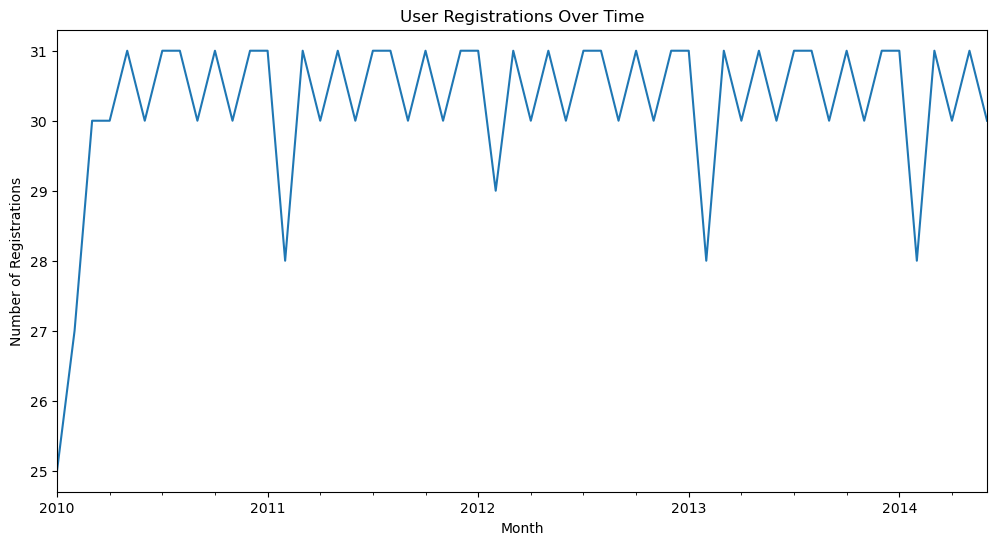

In [10]:
# Conversion de date_account_created à datetime si ce n'est pas déjà le cas
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_account_created'].value_counts().resample('M').count().plot(kind='line', figsize=(12, 6))
plt.title('User Registrations Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Registrations')
plt.show()


## Train Dataset

Aperçu des données

In [11]:
print("------head-------")
print(test.head())
print("")
print("------info-------")
print(test.info())
print("")
print("------describe-------")
print(test.describe())


------head-------
           id date_account_created  timestamp_first_active  \
0  5uwns89zht           2014-07-01          20140701000006   
1  jtl0dijy2j           2014-07-01          20140701000051   
2  xx0ulgorjt           2014-07-01          20140701000148   
3  6c6puo6ix0           2014-07-01          20140701000215   
4  czqhjk3yfe           2014-07-01          20140701000305   

   date_first_booking     gender   age signup_method  signup_flow language  \
0                 NaN     FEMALE  35.0      facebook            0       en   
1                 NaN  -unknown-   NaN         basic            0       en   
2                 NaN  -unknown-   NaN         basic            0       en   
3                 NaN  -unknown-   NaN         basic            0       en   
4                 NaN  -unknown-   NaN         basic            0       en   

  affiliate_channel affiliate_provider first_affiliate_tracked signup_app  \
0            direct             direct               untracked 

Exploration des valeurs manquantes

In [12]:
print(test.isnull().sum())

print('--------------------------------------------------')


missing_percentage = test.isnull().mean() * 100
missing_percentage

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64
--------------------------------------------------


id                           0.000000
date_account_created         0.000000
timestamp_first_active       0.000000
date_first_booking         100.000000
gender                       0.000000
age                         46.502190
signup_method                0.000000
signup_flow                  0.000000
language                     0.000000
affiliate_channel            0.000000
affiliate_provider           0.000000
first_affiliate_tracked      0.032208
signup_app                   0.000000
first_device_type            0.000000
first_browser                0.000000
dtype: float64

Exploration des types de données et des valeurs uniques

In [13]:
# Afficher les types de données
print(test.dtypes)
print('--------------------------------------------------')
# Afficher le nombre de valeurs uniques pour chaque colonne
print(test.nunique())
print('--------------------------------------------------')
# Afficher les valeurs uniques pour quelques colonnes spécifiques
print(test['gender'].unique())
print(test['signup_method'].unique())
print(test['language'].unique())
print(test['affiliate_channel'].unique())

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking         float64
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
dtype: object
--------------------------------------------------
id                         62096
date_account_created          92
timestamp_first_active     62096
date_first_booking             0
gender                         4
age                          124
signup_method                  4
signup_flow                    7
language                      24
affiliate_channel              7
affiliate_provider            17
first_affiliate_tracked        7
signup_app    

Exploration des distributions des variables

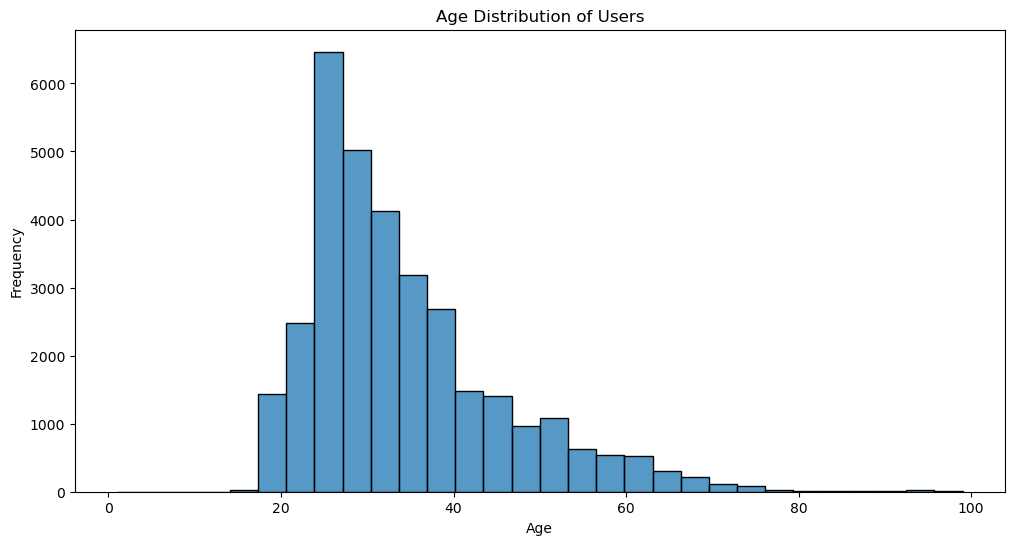

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(test[test['age'] < 100]['age'], bins=30, kde=False)  # Supposant que l'âge a des valeurs aberrantes au-dessus de 100
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


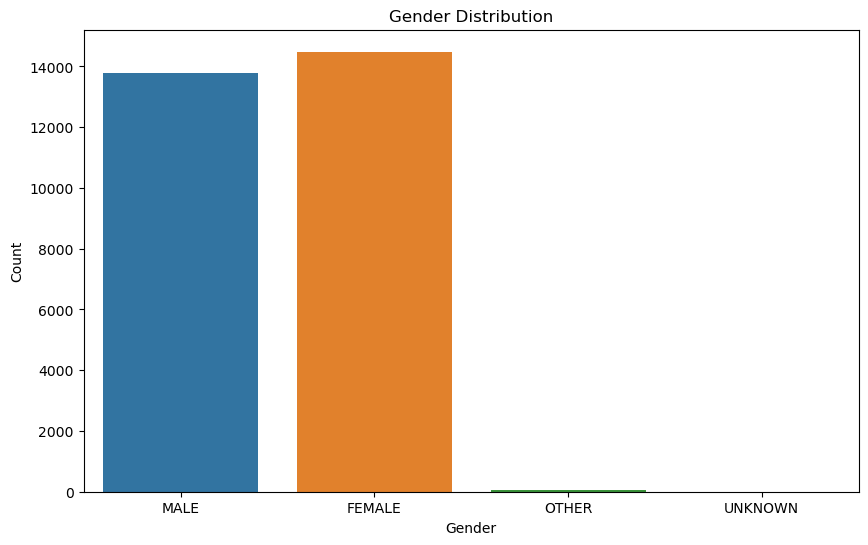

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test, x='gender', order=['MALE', 'FEMALE', 'OTHER', 'UNKNOWN'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


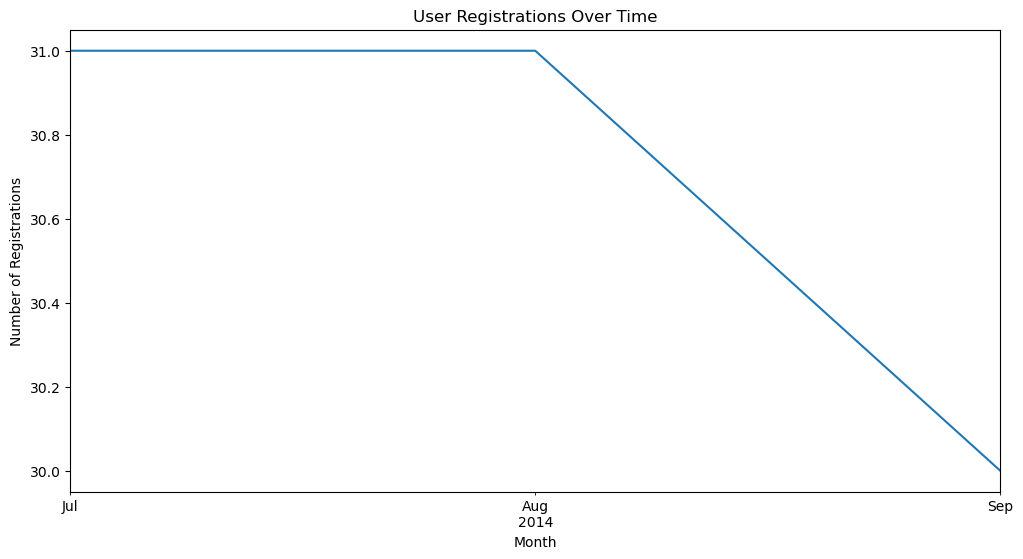

In [16]:
# Conversion de date_account_created à datetime si ce n'est pas déjà le cas
test['date_account_created'] = pd.to_datetime(test['date_account_created'])
test['date_account_created'].value_counts().resample('M').count().plot(kind='line', figsize=(12, 6))
plt.title('User Registrations Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Registrations')
plt.show()


## Sessions dataset

Aperçu des données

In [17]:
print("------head-------")
print(sessions.head())
print("")
print("------info-------")
print(sessions.info())
print("")
print("------describe-------")
print(sessions.describe())


------head-------
      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                  NaN   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                  NaN   

       device_type  secs_elapsed  
0  Windows Desktop         319.0  
1  Windows Desktop       67753.0  
2  Windows Desktop         301.0  
3  Windows Desktop       22141.0  
4  Windows Desktop         435.0  

------info-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1)

Exploration des valeurs manquantes

In [18]:
print(sessions.isnull().sum())

print('--------------------------------------------------')


missing_percentage = sessions.isnull().mean() * 100
missing_percentage

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64
--------------------------------------------------


user_id           0.326428
action            0.753482
action_type      10.657003
action_detail    10.657003
device_type       0.000000
secs_elapsed      1.287229
dtype: float64

Exploration des distributions des variables

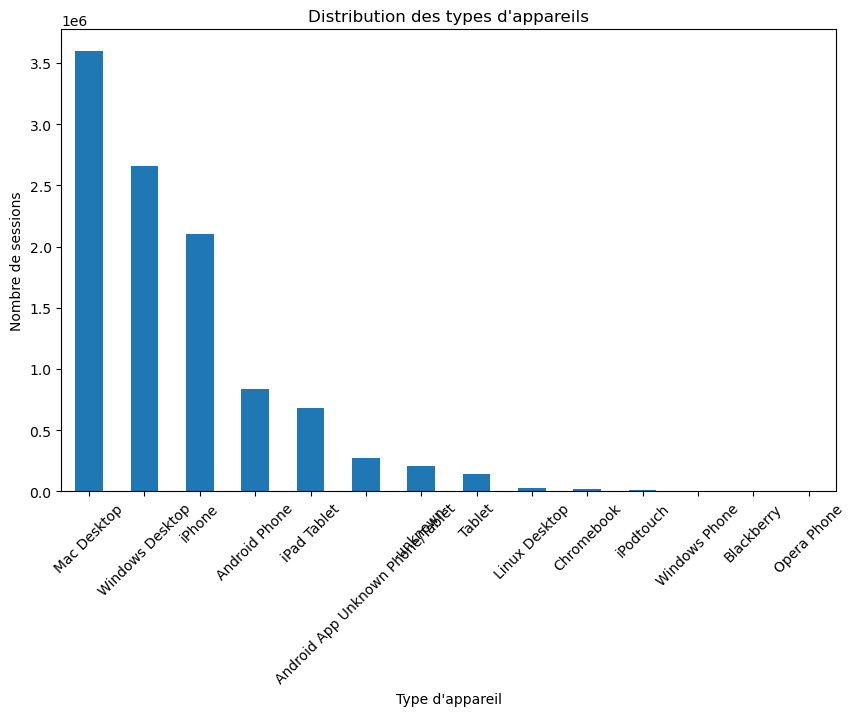

In [19]:

device_counts = sessions['device_type'].value_counts()
plt.figure(figsize=(10, 6))
device_counts.plot(kind='bar')
plt.title('Distribution des types d\'appareils')
plt.xlabel('Type d\'appareil')
plt.ylabel('Nombre de sessions')
plt.xticks(rotation=45)
plt.show()

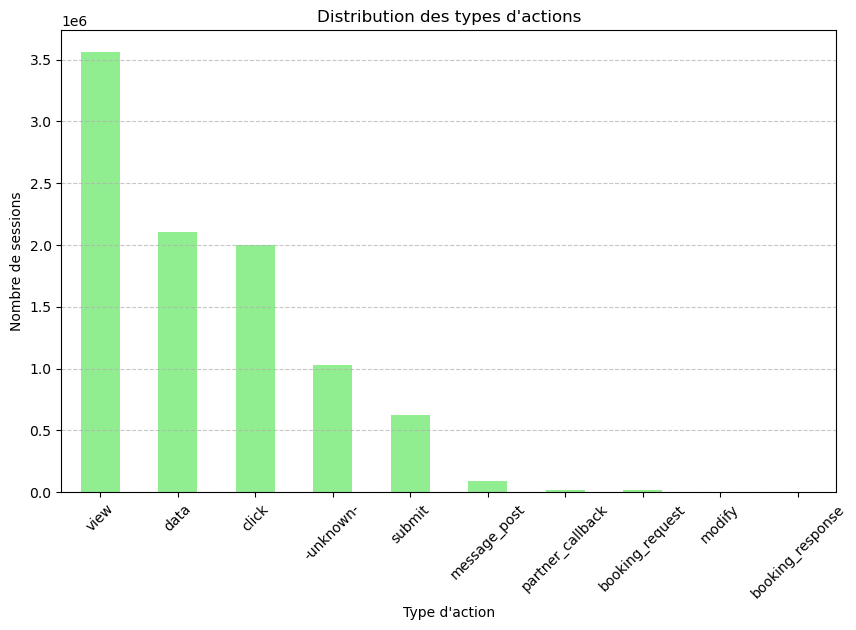

In [20]:
action_type_counts = sessions['action_type'].value_counts()

# Tracer un graphique à barres pour action_type
plt.figure(figsize=(10, 6))
action_type_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution des types d\'actions')
plt.xlabel('Type d\'action')
plt.ylabel('Nombre de sessions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

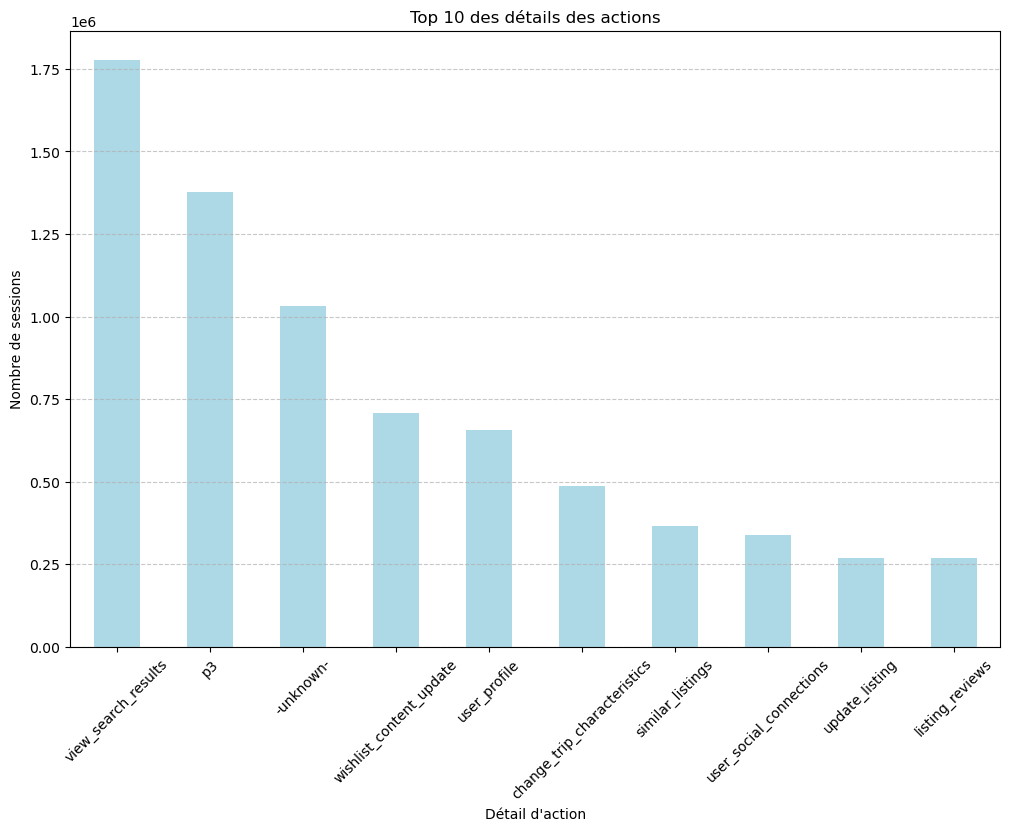

In [21]:
top_action_details = sessions['action_detail'].value_counts().head(10)

# Tracer un graphique à barres pour les 10 action_detail les plus fréquents
plt.figure(figsize=(12, 8))
top_action_details.plot(kind='bar', color='lightblue')
plt.title('Top 10 des détails des actions')
plt.xlabel('Détail d\'action')
plt.ylabel('Nombre de sessions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Concatenation des datatsets

In [22]:
# stocker la variable country_destination
labels = train['country_destination'].values
train = train.drop(['country_destination'], axis=1)

# stocker l'id du test
test_id = test['id']

# calculer le nombre de ligne
train_row = train.shape[0]

# concatenation des datatsets train et test
df = pd.concat((train, test), axis=0, ignore_index=True)

# Aggregation de la data session
sessions['secs_elapsed'] = sessions['secs_elapsed'].fillna(0)
sessions_agg = sessions.groupby('user_id').agg({'secs_elapsed': ['sum', 'mean', 'std', 'count']})
sessions_agg.columns = ['secs_sum', 'secs_mean', 'secs_std', 'secs_count']
sessions_agg = sessions_agg.reset_index()
df = pd.merge(df, sessions_agg, how='left', left_on='id', right_on='user_id')
df = df.drop(['user_id'], axis=1)

# Imputation des données de session manquantes
imputer = SimpleImputer(strategy='constant', fill_value=0)
df[['secs_sum', 'secs_mean', 'secs_std', 'secs_count']] = imputer.fit_transform(df[['secs_sum', 'secs_mean', 'secs_std', 'secs_count']])

# retirer id et date_first_booking
df = df.drop(['id', 'date_first_booking', 'signup_app'], axis=1)

# remplir les valeurs vanquantes avec des nan
df = df.fillna(-1)


## Data Preprocessing

In [23]:
print(train_row)

213451


### Date Account Create

In [24]:
df['date_account_created'] = pd.to_datetime(df['date_account_created'], format='%Y-%m-%d')

df['dac_year'] = pd.DatetimeIndex(df['date_account_created']).year
df['dac_month'] = pd.DatetimeIndex(df['date_account_created']).month
df['dac_day'] = pd.DatetimeIndex(df['date_account_created']).day

df = df.drop(['date_account_created'], axis = 1)

df.head()

,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_device_type,first_browser,secs_sum,secs_mean,secs_std,secs_count,dac_year,dac_month,dac_day
0,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Mac Desktop,Chrome,0.0,0.0,0.0,0.0,2010,6,28
1,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Mac Desktop,Chrome,0.0,0.0,0.0,0.0,2011,5,25
2,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Windows Desktop,IE,0.0,0.0,0.0,0.0,2010,9,28
3,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Mac Desktop,Firefox,0.0,0.0,0.0,0.0,2011,12,5
4,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Mac Desktop,Chrome,0.0,0.0,0.0,0.0,2010,9,14


### Timestamp first active

In [25]:
tfa = np.vstack(df.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)

df['tfa_year'] = tfa[:,0]
df['tfa_month'] = tfa[:,1]
df['tfa_day'] = tfa[:,2]

df = df.drop(['timestamp_first_active'], axis=1)

In [26]:
df.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_device_type,first_browser,secs_sum,secs_mean,secs_std,secs_count,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Mac Desktop,Chrome,0.0,0.0,0.0,0.0,2010,6,28,2009,3,19
1,MALE,38.0,facebook,0,en,seo,google,untracked,Mac Desktop,Chrome,0.0,0.0,0.0,0.0,2011,5,25,2009,5,23
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Windows Desktop,IE,0.0,0.0,0.0,0.0,2010,9,28,2009,6,9
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Mac Desktop,Firefox,0.0,0.0,0.0,0.0,2011,12,5,2009,10,31
4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Mac Desktop,Chrome,0.0,0.0,0.0,0.0,2010,9,14,2009,12,8


### Age

In [27]:
def user_age(age):
    if age < 0 or age > 85:
        return 'NA'
    
    age_groups = {
        15: 15,
        25: 25,
        35: 35,
        45: 45,
        55: 55,
        65: 65,
        75: 75,
        85: 85
    }
    for upper_bound in sorted(age_groups.keys()):
        if age <= upper_bound:
            return age_groups[upper_bound]
    return 'NA'

df['age'] = np.array([user_age(x) for x in df.age])
df_age = pd.get_dummies(df.age, prefix = 'age')
df = pd.concat((df, df_age), axis = 1)

df.drop(['age'], axis = 1, inplace = True)

In [28]:
df.head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_device_type,first_browser,secs_sum,...,tfa_day,age_15,age_25,age_35,age_45,age_55,age_65,age_75,age_85,age_NA
0,-unknown-,facebook,0,en,direct,direct,untracked,Mac Desktop,Chrome,0.0,...,19,0,0,0,0,0,0,0,0,1
1,MALE,facebook,0,en,seo,google,untracked,Mac Desktop,Chrome,0.0,...,23,0,0,0,1,0,0,0,0,0
2,FEMALE,basic,3,en,direct,direct,untracked,Windows Desktop,IE,0.0,...,9,0,0,0,0,0,1,0,0,0
3,FEMALE,facebook,0,en,direct,direct,untracked,Mac Desktop,Firefox,0.0,...,31,0,0,0,1,0,0,0,0,0
4,-unknown-,basic,0,en,direct,direct,untracked,Mac Desktop,Chrome,0.0,...,8,0,0,0,1,0,0,0,0,0


### One Hot Encoding

In [29]:
OHE_feat = ['gender', 
            'signup_method', 
            'signup_flow', 
            'language', 
            'affiliate_channel', 
            'affiliate_provider', 
            'first_affiliate_tracked', 
            'first_device_type', 
            'first_browser']

for f in OHE_feat:
    df_work = pd.get_dummies(df[f], prefix=f, dummy_na=True)
    df.drop([f], axis = 1, inplace = True)
    df = pd.concat((df, df_work), axis = 1)
    
df.head()

,secs_sum,secs_mean,secs_std,secs_count,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,...,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_browser_nan
0,0.0,0.0,0.0,0.0,2010,6,28,2009,3,19,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,2011,5,25,2009,5,23,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,2010,9,28,2009,6,9,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,2011,12,5,2009,10,31,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,2010,9,14,2009,12,8,...,0,0,0,0,0,0,0,0,0,0


## Label Encoding

In [30]:
vals = df.values
X = vals[:train_row]
le = LabelEncoder()
y = le.fit_transform(labels) 
X_test = vals[train_row:]

## XGBoost

In [31]:
!pip install scikit-optimize

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier

In [32]:
# Définir l'espace de recherche des hyperparamètres
search_spaces = {
    'learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'n_estimators': Integer(50, 300)
}

# Créer un modèle XGBClassifier
xgb_model = XGBClassifier(objective='multi:softprob', seed=1)

# Configurer l'optimisation bayésienne
opt = BayesSearchCV(xgb_model, search_spaces, n_iter=32, scoring='accuracy', cv=3, n_jobs=-1, return_train_score=True, refit=True)

# Exécuter l'optimisation
opt.fit(X, y)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres: ", opt.best_params_)
print("Meilleur score: ", opt.best_score_)

# Utiliser le meilleur modèle
best_model = opt.best_estimator_
y_pred = best_model.predict_proba(X_test)


Meilleurs paramètres:  OrderedDict([('colsample_bytree', 0.9647118862303394), ('learning_rate', 0.01), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 50), ('subsample', 0.5)])
Meilleur score:  0.6086877246300275


In [ ]:
xgb = XGBClassifier(max_depth=6, learning_rate=0.2, n_estimators=43,
                    objective='multi:softprob', subsample=1, colsample_bytree=0.5, seed=1)                  
xgb.fit(X, y)
y_pred = xgb.predict_proba(X_test)

In [ ]:
print(y_pred)

In [33]:
# Obtenir les indices des 5 meilleures prédictions pour chaque utilisateur
top_5_indices = np.argsort(-y_pred, axis=1)[:, :5]
top_5_countries = le.inverse_transform(top_5_indices.flatten()).reshape(top_5_indices.shape)

# Creation d'un DataFrame pour la soumission
submission_entries = []
for i, user_id in enumerate(test_id):
    for country in top_5_countries[i]:
        submission_entries.append([user_id, country])

submission_df = pd.DataFrame(submission_entries, columns=['id', 'country'])

# Écriture du DataFrame dans un fichier CSV
submission_df.to_csv('submission2.csv', index=False)
print("Fichier de soumission 'submission.csv' créé avec succès!")


Fichier de soumission 'submission.csv' créé avec succès!
